<a href="https://colab.research.google.com/github/alecmeade/cs242_final_alec_daniel/blob/master/deep_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Python Imports
!pip install tensorflow_model_optimization

import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import pickle
import tempfile
import scipy.sparse
import shutil

import tensorflow as tf
import tensorflow_model_optimization as tfmot
import zipfile

from collections import defaultdict
from enum import Enum
from google.colab import drive
# Mounts your personal google drive onto the current machine
drive.mount('/content/gdrive', force_remount=True)
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from tensorflow.keras import datasets, layers, models

Mounted at /content/gdrive


In [0]:
def isWeightLayer(layer):
  """Determines whether a layer in a neural network has any weights.
  Args:
    layer: A tf.layer object
  Returns:
    A boolean indicating if the layer contains weights.
  """
  weight_biases = layer.get_weights()
  return len(weight_biases) > 0

def getLayerName(layer):
  """Gets the name of a tensfor flow layer without any appended wrappers.
  Args:
    layer: A tf.layer object
  Returns:
    A cleaned str containing the layer name.
  """
  return layer.name.replace('prune_low_magnitude_', '')

def modelToCsr(model, nbit=None):
  """Converts a model to a list of compressed sparse row matrices.
  Args:
    model: A tf.Model
    nbit: A number of bits to reduce the data type of the matrix. If none no
      data type changes will take place. Only 32, 8 and None are supported. 8
      bit converts to int8 to save additional space.
  Returns:
    A list of lists where the nested list contains the sparse row format 
    matrices of the weights and biases of the layer respectively. Also returns
    a tuple containing (number of values in dense representation, num values in
    sparse representation, percentage reduction of values)."""
  
  csr_weights = []
  number_reductions = {}

  # Track the overall compression due to transformation to CSR.
  num_values_dense = 0
  num_values_csr = 0
  
  # Determine if any dtype transformations are required.
  csr_dtype = None
  if nbit == 32:
    csr_dtype = np.float32
  elif nbit == 16:
    csr_dtype = np.float16
  elif nbit == 8:
    csr_dtype = np.int8

  for layer in model.layers:
    if isWeightLayer(layer):
      layer_name = getLayerName(layer)
      csr_weights.append([])

      for w_mtrx in layer.get_weights():
        w = w_mtrx.reshape(-1)        
        csr = None
        if csr_dtype is not None:
          if nbit == 8:
            # If 8 bit is requested we convert to int8 representation which
            # will later be scaled back to float8 when calling csrToModel.
            scale = (2 ** nbit) - 1
            w = np.round(w * scale)
          csr = csr_matrix(w, dtype=csr_dtype)
        else:
          csr = csr_matrix(w)

        num_values_dense += np.product(w_mtrx.shape)
        num_values_csr += csr.nnz
        csr_weights[-1].append(csr)
  
  # Determine the overall reduction in values from converting to CSR.
  num_values_reduction = 100.0 * num_values_csr / num_values_dense

  return csr_weights, (num_values_dense, num_values_csr, num_values_reduction)

def csrToModel(csr_weights, model, nbit=None):
  """Converts a model to a list of compressed sparse row matrices.
  Args:
    csr_weights: A list of csr_matrices created by modelToCSR
    model: A model to overwrite the layers.
    nbit: Indicates the size of the provided csr_weights matrix dtype. Only 8
      bit and None are supported. 8 bit requires a scaling from int8 to float32.
  Returns:
    A populated model created from the csr_weights and model_ctor."""
  
  # Creates a new model.
  dense_weights = []

  # Converts csr matrices to dense representation.
  for layer in csr_weights:
    dense_weights.append([])
    for csr_mtrx in layer:
      if nbit == 16:
        # Special case with np.float16 cannot be directly converted to dense.
        csr_mtrx = csr_mtrx.astype(np.float32)

      dense_mtrx = np.array(csr_mtrx.todense())
      if nbit == 8:
        # Scales the dense matrix to float 32 if it was compressed to int8.
        scale = (2 ** nbit) - 1
        dense_mtrx = dense_mtrx.astype(np.float32) / scale
      dense_weights[-1].append(dense_mtrx)
  
  # Sets the weights in each corresponding layer of the created model.
  i = 0
  for layer in model.layers:
    if isWeightLayer(layer):
      layer_w = layer.get_weights()
      for j in range(len(layer_w)):
        layer_w[j] = dense_weights[i][j].reshape(layer_w[j].shape)
      layer.set_weights(layer_w)
      i += 1
  return model

class CSRHuffmanCoder():
  """An entropy encoder for a list of matrices generated by modelToCSR. 
  Specfically, the npz format utilizes gzip compression, a variant of Huffman
  coding.
  """
  def __init__(self, file_path_prefix="/tmp/model_%d"):
    self.file_paths = []
    # The prefix to append to each file name for each matrix.
    self.file_path_prefix = file_path_prefix

  def encode(self, csr_weights):
    """Compresses a list of csr matrices.
    Args:
      csr_weights: A list of weight matrices created by modelToCSR.
    Returns:
      The total memory of the written files in kb.
    """
    self.file_paths = []
    total_kb = 0
    idx = 0
    for i, layer in enumerate(csr_weights):
      self.file_paths.append([])
      for j, mtrx in enumerate(layer):
        mtrx_path = self.file_path_prefix % idx
        self.file_paths[-1].append(mtrx_path)
        scipy.sparse.save_npz(mtrx_path, mtrx)
        total_kb += os.path.getsize(mtrx_path + '.npz')
        idx += 1
    return total_kb / 1000.0

  def decode(self):
    """Decompresses a list of csr matrices.
    Returns:
      Converts all written npz files into a list of spare csr matrices that
      match the format of csrToModel.
    """
    csr_weights = []
    for path_group in self.file_paths:
      csr_weights.append([])
      for path in path_group:
        csr_weights[-1].append(scipy.sparse.load_npz(path + '.npz'))

    return csr_weights

def getSizeRecursive(path):
  """Gets the size of a directory in kb.
  Args:
    path: The file path to the directory.
  Returns:
    The size of all the directory contents in kb.
  """
  total_size = 0
  for dir_path, dir_names, file_names in os.walk(path):
    for f in file_names:
      fp = os.path.join(dir_path, f)
      total_size += os.path.getsize(fp)
  return total_size / 1000.0
    
def clearTempFiles(path='/tmp'):
  """Clears temporary compressed files and recreates the provided directory.
  Args: 
    path: The path to the directory containing temp files.
  """    
  if os.path.exists(path):
    shutil.rmtree(path)

  os.mkdir('/tmp')

class Dataset():
  """Generic class to represent a dataset."""

  def __init__(self, x_train, y_train, x_test, y_test, batch_size, seed=0):
    self.x_train = x_train
    self.y_train = y_train
    self.x_test = x_test
    self.y_test = y_test
    self.batch_size = batch_size
    self.num_train_samples = self.x_train.shape[0]

    # Random seed created to allow consistency in testing.
    self.seed = seed
    self.train_dataset = self.convertDatasetToBatches()

    # Epochs per steps is used throughout training to properly time different
    # stages in the compression pipeline.
    self.epoch_steps = np.floor(
          1.0 * self.num_train_samples / self.batch_size
        ).astype(np.int32)

  def convertDatasetToBatches(self):
    """Splits the training dataset into batches."""
    tf.compat.v1.set_random_seed(self.seed)
    train_dataset = tf.data.Dataset.from_tensor_slices((self.x_train,
                                                        self.y_train))
    # Train dataset is shuffled with a consistent random seed and any remainder
    # data is dropped to ensure all batches are equal in size.
    train_dataset = train_dataset.shuffle(self.num_train_samples, 
                                           seed=self.seed, 
                                           reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(self.batch_size, drop_remainder=True)
    return train_dataset

def loadDecoderModelAndData(folder_path, batch_size=None, nbit=8):
  """Loads a decoder model from drive along with its test and train data.
  Args:
    folder_path: The path to the decoder model in drive.
  Returns:
    A tuple containg a model and Dataset object.
  """
  inputs = np.load(folder_path + "input.npy")
  huffman = CSRHuffmanCoder('/tmp/inputs_%d')
  w = inputs
  scale = (2 ** nbit) - 1
  w = np.round(w * scale)
  w = w.reshape(-1)
  inputs_kb = huffman.encode([[csr_matrix(w, dtype=np.int8)]])
  tf.constant(huffman.decode()[0][0].astype(np.float32).todense() * scale ,
              dtype=tf.float32)
      
  outputs = tf.constant(np.load(folder_path + "output.npy"), dtype=tf.float32)
  model = dense_model = tf.keras.models.load_model(folder_path + "model")
  x_train = inputs
  y_train = outputs
  x_test  = inputs
  y_test  = outputs
  if batch_size is None:
    batch_size = x_train.shape[0]
  return model, Dataset(x_train, y_train, x_test, y_test, batch_size),inputs_kb

In [0]:
class MetricsTracker():
  """Tracks multiple metrics during model training and can generate plots."""
  def __init__(self, metrics=None):
    self.metrics = defaultdict(list)
    # If metrics are provided as an argument populate them.
    if metrics is not None:
      for k, v in metrics.items():
        self.metrics[k] = v
    
    self.step_markers = {}

  def printMetricsAtIndex(self, metrics, index):
    """Prints the metric at the provided index from a list of provided metrics.
    Args:
      metrics: A list of strs with metric names.
      index: The index from which to retrieve the metrics.
    """
    metric_string = ""
    for m_name in metrics:
      if m_name in self.metrics:
        m_value = self.metrics[m_name][index]
        metric_string += "%s: %0.2f | " % (m_name, m_value)
    print (metric_string)
    
  def concatLayer(self, metric_type, layer_name):
    """Creates a unique metric name that includes the layer name.
    Args:
      metric_type: The name of the metric.
      layer_name: The name of the layer for which the metric corresponds.
    Returns:
      The layer specific metric name.
    """
    return "%s_%s" % (metric_type, layer_name)

  def addMetric(self, metric_type, val, layer_name=None):
    """Appends a new value for a given metric.
    Args:
      metric_type: The metric name to add the value to.
      val: The value of the metric.
      layer_name: The optional layer that the metric is calculated over.
    """
    if layer_name is not None:
      metric_type = self.concatLayer(metric_type, layer_name)

    self.metrics[metric_type].append(val)

  def addStepMarker(self, marker_name, step):
    """Adds a key value pair marker used for vertical lines on plots.
    Args:
      marker_name: The name of the event.
      step: The training step the event occured on.
    """
    self.step_markers[marker_name] = step

  def getMetrics(self, in_filter=None, ex_filter=None):
    """Gets a list of metrics tracked by the tracker.
    Args:
      in_filter: A string that retrieved metrics must contain.
      ex_filter: A string that retrieved metrics must not contain.
    Returns:
      A list of metric names as strings.
    """
    metric_names = []
    for m in self.metrics.keys():
      add_name = True

      # Inclusive filters.
      if in_filter is not None and in_filter not in m: 
        add_name = False

      # Exclusive filters.
      if ex_filter is not None and ex_filter in m:   
        add_name = False
      
      if add_name:
        metric_names.append(m)

    return metric_names

  def plotMetrics(self, title, y_metrics, xlim = None, ylim = None, 
                  show_markers = True, x_title=True):
    """Plots a time series of a set of metrics that the tracker contains.
    Args:
      title: The plot title.
      y_metrics: The names of the y_metrics that the tracker has.
      xlim: Optional array of [min, max] for x vals.
      ylim: Optional array of [min, max] for y vals.
      show_markers: Whether or not to show marked events as vertical lines.
    """
    plt.figure(figsize=(15, 3))
    for m in y_metrics:
      plt.plot([i + 1 for i in range(len(self.metrics[m]))],
               self.metrics[m], label=m)
    plt.legend()
    
    # Display marked events as vertical lines.
    if show_markers:
      for i, (k, v) in enumerate(self.step_markers.items()):
        plt.axvline(v, label="%d | %s" % (i, k), linestyle='dashed')

    if xlim is not None:
      plt.xlim(xlim)

    if ylim is not None:
      plt.ylim(ylim)

    plt.ylabel(title)
    if x_title:
      plt.xlabel("Training Steps")
    plt.show()

def plotFrames(golden_frames, predicted_frames, num_images=None):
  frame_shape = golden_frames.shape
  if num_images is None:
    num_images = int(frame_shape[0])
  fig, axes = plt.subplots(num_images, 3, figsize=(30, 30))
  for i in range(num_images):
    golden_image = golden_frames[i]
    axes[i, 0].imshow(golden_image)
    predicted_image = predicted_frames[i]
    axes[i, 1].imshow(predicted_image)
    diff_image = tf.math.abs(golden_image - predicted_image)
    axes[i, 2].imshow(diff_image)
  plt.tight_layout()
  plt.show()

In [0]:
# Calculate the psnr error between the golden frames and the predicted frames.
def psnrLoss(y_true, y_pred, as_loss=True):
  '''
  y_true: A tf.tensor representing the set of original sequential frames.
  y_pred: A tf.tensor reprsenting the set of predicted frames. 

  return: The psnr between the two transformed in some way to fit with the 
  understanding of error.
  '''
  psnr = tf.image.psnr(y_true, y_pred, max_val = 1.0)
  
  if as_loss:
    return 50 - psnr
  else:
    return psnr

# Calculate the ssim error between the golden frames and the predicted frames.
def ssimLoss(y_true, y_pred, as_loss=True):
  '''
  y_true: A tf.tensor representing the set of original sequential frames.
  y_pred: A tf.tensor reprsenting the set of predicted frames. 

  return: The sse between the two transformed in some way to fit with the 
  understanding of error.
  '''
  ssim = tf.image.ssim(y_true, y_pred, max_val = 1)

  if as_loss:
    return 1 - ssim
  else:
    return ssim

# Load the vgg model globally so that you do not need to load it
# everytime. If there is a way to define a static variable in python I will use 
# that instead.
vgg_model = tf.keras.applications.VGG16(include_top=False,
                                        input_shape=(1024,2048,3))
vgg_model.trainable = False

# Calculate the vgg error between the golden frames and the predicted frames.
def vggLoss(y_true, y_pred, as_loss=True):
  '''
  y_true: A tf.tensor representing the set of original sequential frames.
  y_pred: A tf.tensor reprsenting the set of predicted frames. 

  return: The vgg between the two transformed in some way to fit with the 
  understanding of error.
  '''
  # golden_output = vgg_model(y_true)
  # predicted_output = vgg_model(y_pred)

  # diff_frames = predicted_output - golden_output
  # return tf.math.reduce_mean(tf.math.square(diff_frames))
  return 0

In [0]:
class DeepCompressor():
  """A class that implements a deep compression pipeline from 
    https://arxiv.org/pdf/1510.00149.pdf without Huffman coding."""
  def __init__(self, 
               model, 
               dataset,
               loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
                   from_logits=True),
               epochs = 10, 
               pruning_start_stop = None, 
               quantization_start_stop = None,
               prune_frequency = 0.1, 
               initial_sparsity = 0.1,
               final_sparsity =0.7, 
               num_clusters = 16,
               floating_point_bits = None):
    """Intializes the deep compressor.
    Args:
      model: A tensorflow model to compress.
      dataset: A Dataset class object containg test and train data.
      loss_fn: A loss function for training the model.
      epochs: The number of epochs to run the compress:
      pruning_start_stop: An array of the start and stop epochs for pruning of
        weights. If None, no pruning occurs.
      quantization_start_stop: An array of the start and stop epochs for 
        quantization. If None no quantization occurs.
      prune_frequency: A decimal indicating the fraction of an epoch with which
        to reprune the network.
      initial_sparsity: An initial sparsity to begin pruning [0, 1].
      final_sparsity: The final sparsity in the network after pruning [0, 1].
      num_clusters: The number of weight clusters to maintain after 
        quantization. This is determined per layer.
      floating_point_bits: The number of bits to truncate values in the network
        to. If None then no truncation occurs.
    """

    print ("Intializing.")
    self.data = dataset
    self.model = model
    self.loss_fn = loss_fn
    self.step = 0
    self.epochs = epochs

    # Adjsut pruning start and stop to be in steps instead of epochs.
    self.pruning_start_stop = None
    if pruning_start_stop is not None:
      self.pruning_start_stop = [int(pruning_start_stop[0] * self.data.epoch_steps),
                                 int(pruning_start_stop[1] * self.data.epoch_steps)]

    # Setup pruning parameters.
    self.pruning_params = {}
    self.prune_frequency = int(prune_frequency * self.data.epoch_steps)
    self.initial_sparsity = initial_sparsity
    self.final_sparsity = final_sparsity
    self.prune_masks = {}
    if self.pruning_start_stop is not None:
      prune_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
              initial_sparsity = self.initial_sparsity,
              final_sparsity = self.final_sparsity,
              begin_step = self.pruning_start_stop[0],
              end_step = self.pruning_start_stop[1],
              frequency = self.prune_frequency)
      }
      # Create pruning wrapper.
      self.model = tfmot.sparsity.keras.prune_low_magnitude(self.model,
                                                            **prune_params)

    # Reset model optimizer after pruning wrapper is in place since it is
    # removed.
    self.model.optimizer = tf.keras.optimizers.Adam()

    # Adjsut quantization start and stop to be in steps instead of epochs.
    self.quantization_start_stop = None
    if quantization_start_stop is not None:
      self.quantization_start_stop = [int(quantization_start_stop[0] * self.data.epoch_steps),
                                      int(quantization_start_stop[1] * self.data.epoch_steps)]
      
    # Assign floating bits and check for valid input.
    self.num_clusters = num_clusters
    self.floating_point_bits = floating_point_bits
    assert self.floating_point_bits in [None, 8, 16, 32]
    
    # Walk the layers in the model and determine which have trainable weights.
    # Also store a mapping between trainable vars in layer names for use during
    # training to map gradients to the proper layers.
    self.weight_cluster_map = {}
    self.weight_layers = {}
    self.trainable_vars_layer_map = {}
    for layer in model.layers: 
      layer_name = getLayerName(layer)
      if isWeightLayer(layer):
        # Only include weight layers.
        self.weight_layers[layer_name] = True

      for v in layer.trainable_variables: 
        if self.isTrainableVarWeight(v):
          self.trainable_vars_layer_map[v.name] = layer_name

    # Initialize pruning masks with all ones.
    self.createPruneMasks()

    # Define metric names for metrics tracked by the compressor.
    self.TEST_LOSS       = "TEST_LOSS"
    self.TEST_ACC        = "TEST_ACC"
    self.TEST_PSNR       = "TEST_PSNR"
    self.TEST_SSIM       = "TEST_SSIM"
    self.TEST_VGG        = "TEST_VGG"

    self.TRAIN_LOSS      = "TRAIN_LOSS"
    self.TRAIN_ACC       = "TRAIN_ACC"
    self.TRAIN_PSNR      = "TRAIN_PSNR"
    self.TRAIN_SSIM      = "TRAIN_SSIM"
    self.TRAIN_VGG       = "TRAIN_VGG"

    self.SPARSITY        = "SPARSITY"
    self.NUM_WEIGHTS     = "NUM_WEIGHTS"
    self.UNIQUE_WEIGHTS  = "UNIQUE_WEIGHTS"
    self.MODEL_SIZE      = "MODEL_SIZE"
  
    self.metrics_tracker = MetricsTracker()
    print ("Intializing Complete.")

  def updateLayerMetrics(self):
    """Calculates layer specific metrics i.e, sparsity, num_weights and 
      unique_weights and appends them to the tracker."""

    all_layer_non_zero = 0
    all_layer_total = 0
    all_unique_w = [] 
    for layer in self.model.layers:
      layer_name = getLayerName(layer)
      if layer_name in self.weight_layers:
        weights = layer.get_weights()[0]
        non_zero = np.count_nonzero(weights)
        total = np.prod(weights.shape)
        all_layer_non_zero += non_zero
        all_layer_total += total
        sparsity = (total - non_zero) / total
        unique_w = np.unique(weights)  
        all_unique_w += list(unique_w)

        # Add layer specific metrics to the tracker.
        self.metrics_tracker.addMetric(self.SPARSITY, sparsity, layer_name)
        self.metrics_tracker.addMetric(self.NUM_WEIGHTS, total, layer_name)
        self.metrics_tracker.addMetric(self.UNIQUE_WEIGHTS, len(unique_w),
                                       layer_name)
    
    # Roll up layer specific metrics and compute them for the entire network.
    sparsity = (all_layer_total - all_layer_non_zero) / all_layer_total
    all_unique_w = np.unique(all_unique_w)
    self.metrics_tracker.addMetric(self.SPARSITY, sparsity, "ALL")
    self.metrics_tracker.addMetric(self.NUM_WEIGHTS, all_layer_total, "ALL")
    self.metrics_tracker.addMetric(self.UNIQUE_WEIGHTS, len(all_unique_w), "ALL")

  def weights_kmeans(self, num_clusters, weights):
    """Runs a standard kmeans across weights with linear centroid intialization.
    Args:
      num_clusters: The number of kmeans clusters to create.
      weights: A matrix containing weights to flatten and cluster.
    Returns:
      A tuple of weights now mapped to their centroids and corresponding matrix
      containing class labels for centroids.
    """

    # Only cluster non-zero weights.
    non_zero_weights = weights[(weights != 0)]
    min_w = np.min(non_zero_weights)
    max_w = np.max(non_zero_weights)

    # Linear intialization of clusters.
    num_clusters = min(num_clusters, len(np.unique(non_zero_weights)))
    centroids = np.linspace(min_w, max_w, num_clusters).reshape(-1, 1)
    flat_weights = non_zero_weights.reshape(-1, 1)

    # Train kmeans transformer and fit the weights.
    kmeans_transformer = KMeans(n_clusters=num_clusters, init=centroids)
    kmeans_transformer.fit(flat_weights)
    centroid_labels = kmeans_transformer.predict(flat_weights)
    centroids = kmeans_transformer.cluster_centers_
    clustered_weights = weights
    clustered_weights[(weights != 0)] = centroids[centroid_labels].reshape(-1)

    cluster_labels = np.zeros(weights.shape) - 1
    cluster_labels[(weights != 0)] = centroid_labels
    return clustered_weights, cluster_labels

  def validateModel(self):
    """Validates the current model against the test data and calculates all
    corresponding test output metrics.
    """
    test_loss = tf.keras.metrics.Mean()
    test_psnr = tf.keras.metrics.Mean()
    test_ssim = tf.keras.metrics.Mean()
    test_vgg = tf.keras.metrics.Mean()
    pred = self.model(self.data.x_test, training=False)
    
    loss = self.loss_fn(y_true=self.data.y_test, y_pred=pred)
    psnr = psnrLoss(self.data.y_test, pred, False)
    ssim = ssimLoss(self.data.y_test, pred, False)
    vgg = vggLoss(self.data.y_test, pred, False)

    test_loss.update_state(loss) 
    test_psnr.update_state(psnr) 
    test_ssim.update_state(ssim) 
    test_vgg.update_state(vgg) 

    # Append the metric for each epoch step so that test and train data have
    # a consistent number of samples.
    for i in range(0, self.data.epoch_steps):
      self.metrics_tracker.addMetric(self.TEST_LOSS, test_loss.result())
      self.metrics_tracker.addMetric(self.TEST_PSNR, test_psnr.result())
      self.metrics_tracker.addMetric(self.TEST_SSIM, test_ssim.result())
      self.metrics_tracker.addMetric(self.TEST_VGG, test_vgg.result())

  def createPruneMasks(self):
    """Creates the initial masks for each weight layer of the network to 
    enforce that pruned weights remain pruned during training. The intial
    prune masks contain all ones and therefore prune nothing."""
    for layer in self.model.layers:
      layer_name = getLayerName(layer)
      if layer_name in self.weight_layers:
        weights = layer.get_weights()[0]
        self.prune_masks[layer_name] = np.ones(weights.shape)

  def updatePruneMasks(self):
    """Updates the set of prune masks across layers to mask all weights that
    are zero."""
    for layer in self.model.layers:
      layer_name = getLayerName(layer)
      if layer_name in self.weight_layers:
        weights = layer.get_weights()[0]
        self.prune_masks[layer_name] = (weights != 0)

  def reapplyPruneMasks(self):
    """Applies the currently stored set of pruning masks to the network 
    enforcing that all weights that were previously pruned are reset to 0."""
    for i, layer in enumerate(self.model.layers):
      layer_name = getLayerName(layer)
      if layer_name in self.prune_masks:
        weights_biases = layer.get_weights()
        weights_biases[0] = weights_biases[0] * self.prune_masks[layer_name]
        self.model.layers[i].set_weights(weights_biases)

  def fixBitWeights(self, nbit):
    """Truncates weights and biases in each layer of the network to nbits.
    Args:
      nbit: The number of weights to fix the network to.
    """
    for i, layer in enumerate(self.model.layers):
      layer_name = getLayerName(layer)
      if layer_name in self.weight_layers:
        weights_biases = layer.get_weights()
        for j, w in enumerate(weights_biases):
          weights_biases[j] = self.scaleMtrx(weights_biases[j], nbit)
        
        # Assign the truncated weights to the model.
        self.model.layers[i].set_weights(weights_biases)

  def scaleMtrx(self, mtrx, nbit):
    """Scales a matrix to nbit representation.
    Args:
      mtrx: A np.array or compatiable matrix of floats.
      nbit: The number of bits to scale the matrix to.
    Returns:
      A new copy of a scaled matrix.
    """
    scale = (2 ** nbit) - 1
    return tf.math.round(mtrx * scale) / scale

  def updateWeightClusters(self):
    """Updates each layer of the model to have shared weight clusters. If the
    shared weight clusters are already created, then weights assigned to the
    same centroid are re-averaged to produce a new centroid. This shifting of
    centroids can occur due to momentum when training the model.
    """

    for i, layer in enumerate(self.model.layers):
      layer_name = getLayerName(layer)
      if layer_name in self.weight_layers:
        weights_biases = layer.get_weights()
        if layer_name not in self.weight_cluster_map:
          # Cluster each weight layer into centroids and store the centroid
          # mapping if it has not been created before.
          clustered_weights, centroid_labels = self.weights_kmeans(
              self.num_clusters, 
              weights_biases[0])
        
          centroid_labels = centroid_labels.reshape(clustered_weights.shape) 
          self.weight_cluster_map[layer_name] = centroid_labels
          
          # Only cluster / quantize weights since biases are too few.
          weights_biases[0] = self.prune_masks[layer_name] * clustered_weights

        else:
          # The centroid mapping for weights in the layer already exists. 
          # The mapping to centroids is used to update the centroid value with
          # the new average of the cluster to ensure that the weights 
          # remain shared.
          centroid_labels = self.weight_cluster_map[layer_name]
          clustered_weights = np.zeros(weights_biases[0].shape)
          for label in np.unique(centroid_labels):
            if label == -1:
              # Indicates a zero weight label
              continue

            centroid_mask = (centroid_labels == label)
            centroid_count = np.sum(centroid_mask)
            if centroid_count != 0:
              # Only updates the centroid if it has corresponding weights.
              centroid = np.sum(weights_biases[0] * centroid_mask) / centroid_count
              clustered_weights += (self.prune_masks[layer_name] *
                                    centroid_mask * centroid)

          weights_biases[0] = clustered_weights

        # Assign clustered weights back to the model.
        self.model.layers[i].set_weights(weights_biases)

  def accumulateSharedWeightGradients(self, gradients):
    """Determines the new gradients update for shared weights following the 
    specifications in https://arxiv.org/pdf/1510.00149.pdf. Specifically,
    the gradients of shared weights are added together."""

    for j, var in enumerate(self.model.trainable_variables):
      if var.name in self.trainable_vars_layer_map:
        layer_name = self.trainable_vars_layer_map[var.name]
        if layer_name in self.weight_cluster_map:
          np_grads = np.zeros(gradients[j].shape)
          centroid_labels = self.weight_cluster_map[layer_name]
          prune_mask = self.prune_masks[layer_name]

          for label in np.unique(centroid_labels):
            # For each centroid determine the total gradients by summing the 
            # gradients across all weights.

            if label == -1:
              # Indicates a zero weight label
              continue

            centroid_mask = (centroid_labels == label)
            centroid_update = np.sum(gradients[j] * centroid_mask * prune_mask)              
            np_grads[centroid_mask] = centroid_update

          # Update the existing computed gradients to reflect that gradients
          # for shared weights are cummulative.
          gradients[j] = np_grads

    return gradients 

  def isTrainableVarWeight(self, trainable_var):
    """Determines if a variable is a weight or bias.
    Args:
      trainable_var: A tf trainable var.
    Returns:
      True if the variable represents weights, false if biases.
    """
    return 'kernel' in trainable_var.name

  def train_and_compress(self):
    self.step = 0
    # Create pruning call backs.
    prune_cb = tfmot.sparsity.keras.UpdatePruningStep()
    prune_cb.set_model(self.model)
    prune_cb.on_train_begin()

    for epoch in range(self.epochs):    
      print ("\n*****************\nEpoch: %d | Step: %d" % (epoch, self.step))
      prune_cb.on_epoch_begin(epoch)
      
      for i, (x_batch, y_batch) in enumerate(self.data.train_dataset):
        prune_cb.on_train_batch_begin(batch=i)
        train_loss = tf.keras.metrics.Mean()
        train_psnr = tf.keras.metrics.Mean()
        train_ssim = tf.keras.metrics.Mean()
        train_vgg = tf.keras.metrics.Mean()

        #####################
        # Calculate Loss
        #####################
        pred = None
        loss = None
        psnr = None
        ssim = None
        vgg  = None
        with tf.GradientTape() as tape:
          # Compute all loss metrics on the current training batch.
          pred = self.model(x_batch, training=True)
          loss = self.loss_fn(y_true=y_batch, y_pred=pred)
          psnr = psnrLoss(y_batch, pred, False)
          ssim = ssimLoss(y_batch, pred, False)
          vgg = vggLoss(y_batch, pred, False)

        gradients = tape.gradient(loss, self.model.trainable_variables)

        #####################
        # Pruning Weights
        #####################
        if (self.pruning_start_stop is not None and 
            self.pruning_start_stop[0] <= self.step 
            and self.pruning_start_stop[1] > self.step):
          # Only prune between start and stop epochs.

          if self.pruning_start_stop[0] == self.step:
            print("Pruning | Step: %d" % self.step)
            self.metrics_tracker.addStepMarker("PRUNE_START", self.step)

          self.updatePruneMasks()

          if self.pruning_start_stop[1] == self.step + 1:
            print("Pruning Complete | Step: %d" % (self.step + 1))
            self.metrics_tracker.addStepMarker("PRUNE_END", self.step + 1)
        #####################
        # Quantizing Weights
        #####################
        if (self.quantization_start_stop is not None and 
            self.quantization_start_stop[0] <= self.step 
            and self.quantization_start_stop[1] > self.step):
          # Only quantize between start and stop epochs.

          if self.quantization_start_stop[0] == self.step:
            print("Quantizing | Step: %d" % self.step)
            self.metrics_tracker.addStepMarker("QUANT_START", self.step)
            # Creates the initial set of weight clusters only once.
            self.updateWeightClusters()
          
          # Update gradients to account for shared weights across the matrix.
          gradients = self.accumulateSharedWeightGradients(gradients)

          if self.quantization_start_stop[1] == self.step + 1:
            self.metrics_tracker.addStepMarker("QUANT_END", self.step + 1)

        #####################
        # Reduce Bits
        #####################
        if self.floating_point_bits is not None:
          self.fixBitWeights(self.floating_point_bits)

        #####################
        # Updating Gradients
        #####################  
        # Apply the gradient update. These gradients have possibly been altered
        # by accumulateSharedWeightGradients in the quantization step.
        self.model.optimizer.apply_gradients(zip(gradients, 
                                                self.model.trainable_variables))

        if self.pruning_start_stop is not None:
          # Pruning must occur again after apply gradients because the tf
          # pruning cuts out after pruning_stop step and even zero weights can
          # be updated due to momentum in the optimizer.
          self.reapplyPruneMasks()

        if (self.quantization_start_stop is not None and 
            self.quantization_start_stop[0] <= self.step 
            and self.quantization_start_stop[1] > self.step):
          # Regroup weight clusters to ensure that shared weights are maintained
          # after the gradient update.
          self.updateWeightClusters()


        # Update training metrics at each step.
        train_loss.update_state(loss) 
        train_psnr.update_state(psnr) 
        train_ssim.update_state(ssim) 
        train_vgg.update_state(vgg) 
            
        self.metrics_tracker.addMetric(self.TRAIN_LOSS, train_loss.result())
        self.metrics_tracker.addMetric(self.TRAIN_PSNR, train_psnr.result())
        self.metrics_tracker.addMetric(self.TRAIN_SSIM, train_ssim.result())
        self.metrics_tracker.addMetric(self.TRAIN_VGG, train_vgg.result())
  
        self.updateLayerMetrics()
        self.step += 1

      prune_cb.on_epoch_end(epoch)

      #####################
      # Validating Model
      #####################
      self.validateModel()
      self.metrics_tracker.printMetricsAtIndex([self.TRAIN_LOSS,
                                                self.TEST_LOSS], 
                                               epoch * self.data.epoch_steps)
      
    # Ensure that quantization is the final step of the deep compression 
    # pipeline to make sure that no weights deviate from their shared centroids.
    if self.quantization_start_stop is not None:
      assert self.step == self.quantization_start_stop[1]

    prune_cb.on_train_end()



In [43]:
#######################
# AVAILABLE MODELS
######################
VIDEO_COMPRESSION_MODELS = [
  "Nature_Unet_1_PSNR",
  "Nature_Unet_2_PSNR",
  "Nature_Unet_3_PSNR",
  "Honey_Unet_1_PSNR",
  "Honey_Unet_2_PSNR",
  "Honey_Unet_3_PSNR",
  "Beauty_Unet_1_PSNR",
  "Beauty_Unet_2_PSNR",
  "Beauty_Unet_3_PSNR",
  "HoneyBeePSNR",
]
###################
# Deep Compression
###################
results = []
for model_path in VIDEO_COMPRESSION_MODELS:
  DATA_DIR = "/content/gdrive/My Drive/Data"
  model, dataset, inputs_kb = loadDecoderModelAndData(DATA_DIR + "/" + model_path+ "/", 
                                          batch_size=1, 
                                          nbit=8)
  loss_fn = psnrLoss
  floating_point_bits = 16
  dc = DeepCompressor(
      tf.keras.models.clone_model(model),
      dataset,
      loss_fn = loss_fn,
      epochs = 150, 
      pruning_start_stop = [10, 120], 
      quantization_start_stop = [120, 150],
      prune_frequency = 1, 
      initial_sparsity = 0.1,
      final_sparsity = 0.65, 
      num_clusters = 8,
      floating_point_bits = floating_point_bits)
  dc.train_and_compress()
  results.append([model_path, model, inputs_kb, dc])
  
  # Currently only compress one model at a time.
  break

Intializing.
Intializing Complete.

*****************
Epoch: 0 | Step: 0
TRAIN_LOSS: 41.67 | TEST_LOSS: 40.59 | 

*****************
Epoch: 1 | Step: 8
TRAIN_LOSS: 40.59 | TEST_LOSS: 38.66 | 

*****************
Epoch: 2 | Step: 16
TRAIN_LOSS: 38.67 | TEST_LOSS: 35.28 | 

*****************
Epoch: 3 | Step: 24
TRAIN_LOSS: 35.27 | TEST_LOSS: 34.35 | 

*****************
Epoch: 4 | Step: 32
TRAIN_LOSS: 34.34 | TEST_LOSS: 32.73 | 

*****************
Epoch: 5 | Step: 40
TRAIN_LOSS: 32.75 | TEST_LOSS: 31.67 | 

*****************
Epoch: 6 | Step: 48
TRAIN_LOSS: 31.68 | TEST_LOSS: 30.96 | 

*****************
Epoch: 7 | Step: 56
TRAIN_LOSS: 30.93 | TEST_LOSS: 30.34 | 

*****************
Epoch: 8 | Step: 64
TRAIN_LOSS: 30.31 | TEST_LOSS: 29.71 | 

*****************
Epoch: 9 | Step: 72
TRAIN_LOSS: 29.72 | TEST_LOSS: 29.18 | 

*****************
Epoch: 10 | Step: 80
Pruning | Step: 80
TRAIN_LOSS: 29.24 | TEST_LOSS: 28.86 | 

*****************
Epoch: 11 | Step: 88
TRAIN_LOSS: 28.84 | TEST_LOSS: 28.49 |

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: RuntimeWarning: Explicit initial c

TRAIN_LOSS: 26.32 | TEST_LOSS: 26.34 | 

*****************
Epoch: 121 | Step: 968
TRAIN_LOSS: 26.36 | TEST_LOSS: 26.33 | 

*****************
Epoch: 122 | Step: 976
TRAIN_LOSS: 26.34 | TEST_LOSS: 26.31 | 

*****************
Epoch: 123 | Step: 984
TRAIN_LOSS: 26.33 | TEST_LOSS: 26.28 | 

*****************
Epoch: 124 | Step: 992
TRAIN_LOSS: 26.24 | TEST_LOSS: 26.26 | 

*****************
Epoch: 125 | Step: 1000
TRAIN_LOSS: 26.28 | TEST_LOSS: 26.24 | 

*****************
Epoch: 126 | Step: 1008
TRAIN_LOSS: 26.26 | TEST_LOSS: 26.22 | 

*****************
Epoch: 127 | Step: 1016
TRAIN_LOSS: 26.25 | TEST_LOSS: 26.20 | 

*****************
Epoch: 128 | Step: 1024
TRAIN_LOSS: 26.22 | TEST_LOSS: 26.18 | 

*****************
Epoch: 129 | Step: 1032
TRAIN_LOSS: 26.20 | TEST_LOSS: 26.16 | 

*****************
Epoch: 130 | Step: 1040
TRAIN_LOSS: 26.14 | TEST_LOSS: 26.14 | 

*****************
Epoch: 131 | Step: 1048
TRAIN_LOSS: 26.17 | TEST_LOSS: 26.12 | 

*****************
Epoch: 132 | Step: 1056
TRAIN_LO

Nature_Unet_1_PSNR
Initial Model TF Save Size Kb: 157.68
Input Size 19841.52
Dense: 588 | CSR: 217 | Reduction: 36.904762
Huffman Code Size Kb: 14.19
INFO:tensorflow:Assets written to: /tmp/tf_model_norm/assets
TF Save Size Kb: 953.16
Pickle Save Size Kb: 3.32
TEST LOSS tf.Tensor(20.86634, shape=(), dtype=float32)
TEST PSNR tf.Tensor(29.13366, shape=(), dtype=float32)
TEST SSIM tf.Tensor(0.85652167, shape=(), dtype=float32)


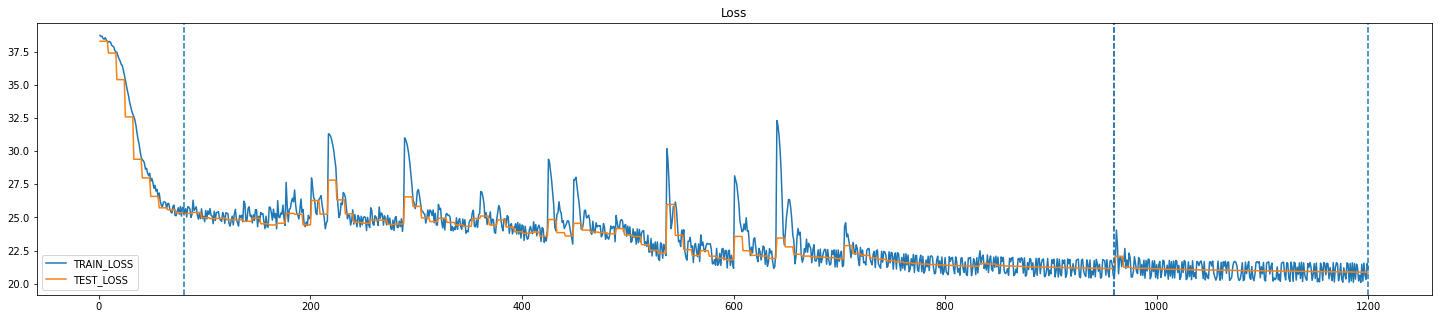

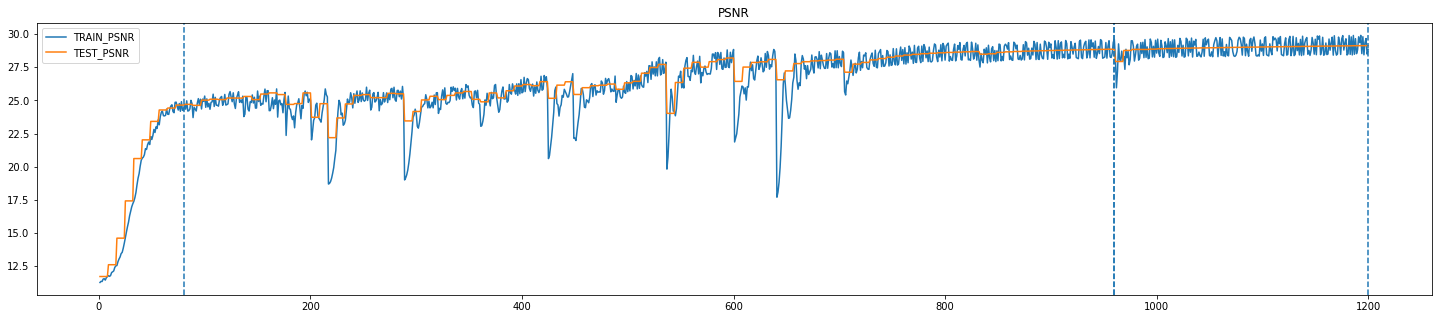

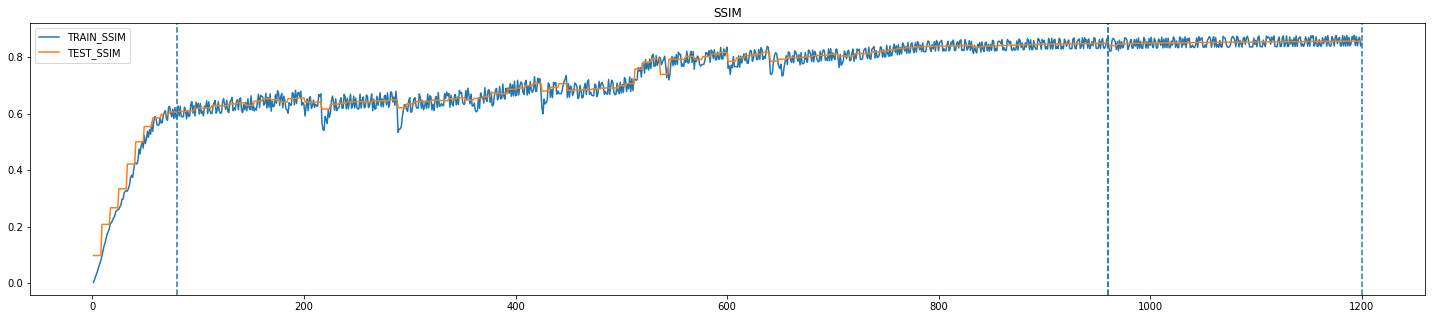

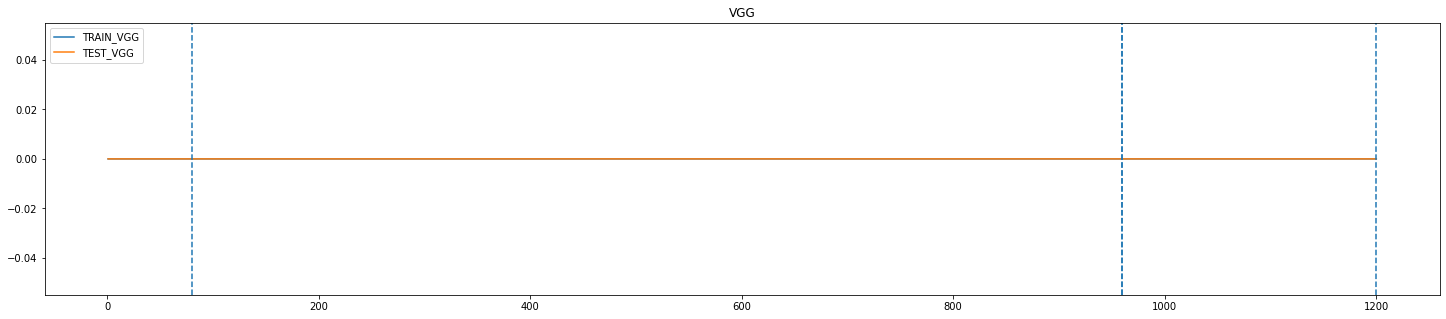

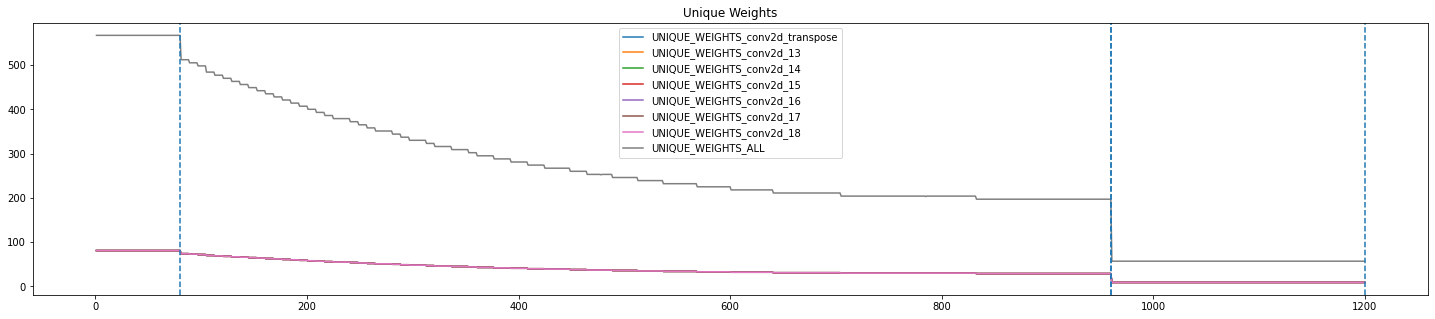

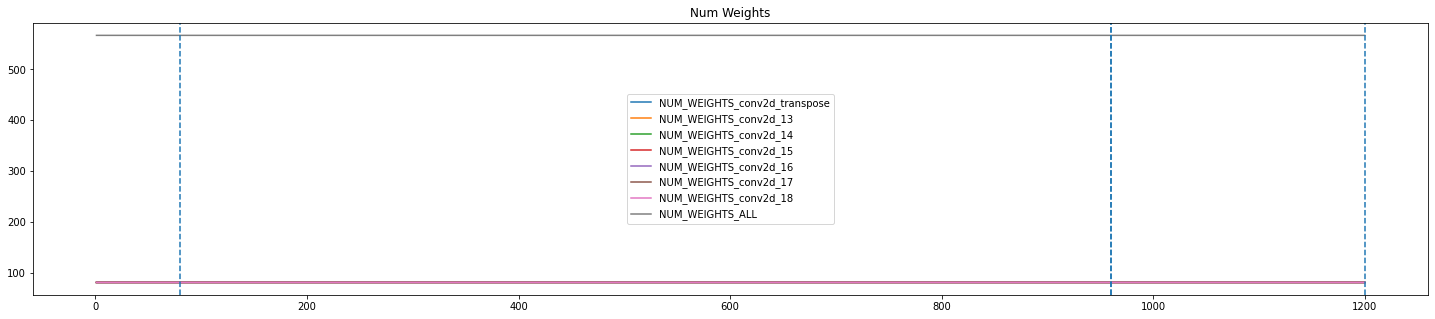

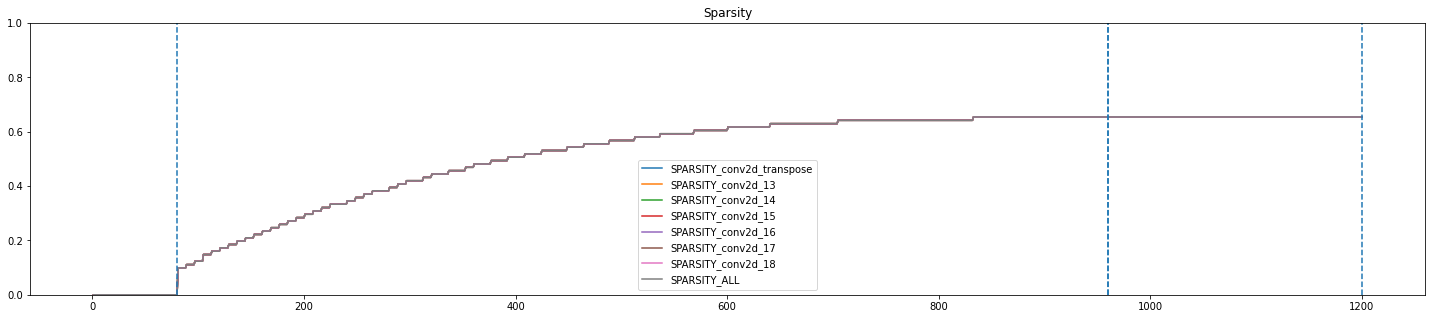

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


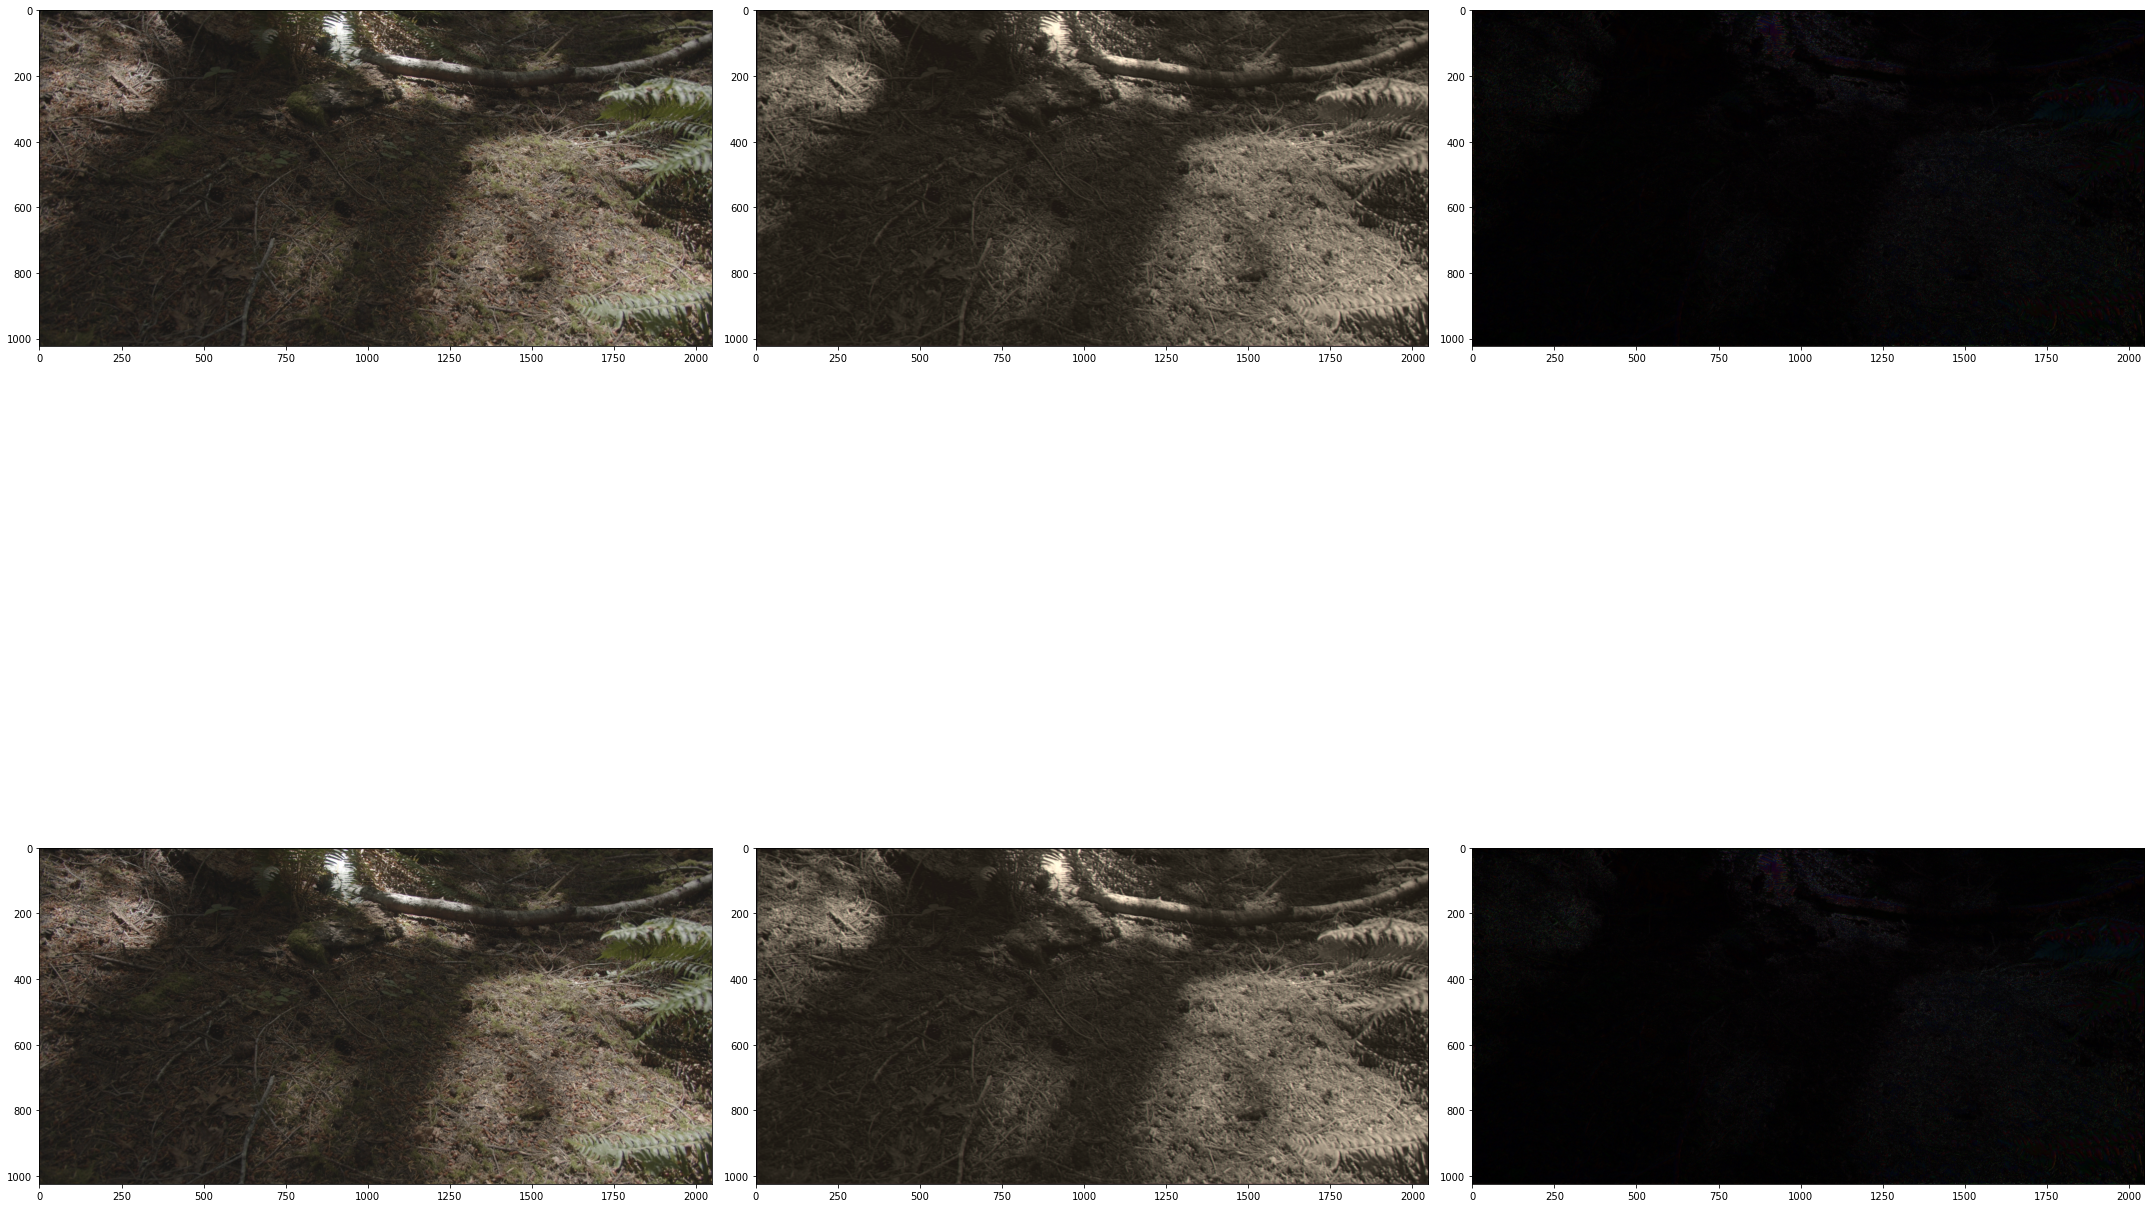

In [57]:
#@title Display Metrics
#######################
# Extract Metrics From Compressed Models
#######################
# Display full analysis of the compressed model at index idx
idx = 0
model_path, initial_model, inputs_kb, dc = results[idx]

initial_model, dataset, inputs_kb = loadDecoderModelAndData(
    DATA_DIR + "/" + VIDEO_COMPRESSION_MODELS[idx]+ "/", 
    batch_size=1, 
    nbit=8)
##################
# Clear Directory
##################
clearTempFiles()
model = dc.model
print(model_path)

###############
# Initial Model Size
###############
DATA_DIR = "/content/gdrive/My Drive/Data"
print ("Initial Model TF Save Size Kb: %0.2f" % getSizeRecursive(DATA_DIR + "/" + model_path+ "/model/"))
print ("Input Size %0.2f" % inputs_kb)

##################
# Convert to CSR
##################

# Update if a different data type is desired for compression than was used for
# training. Any reduction in floating_point_bits to the trained value will
# likely result in a dergradation of model performance.
floating_point_bits = floating_point_bits
csr_weights, stats = modelToCsr(model, floating_point_bits)
print("Dense: %d | CSR: %d | Reduction: %3f" % stats)

#####################################
# Compress and Evaluate Model Sizes
#####################################

#########
# Huffman
##########
huffman_coder = CSRHuffmanCoder()
total_bytes = huffman_coder.encode(csr_weights)
print("Huffman Code Size Kb: %.2f" % total_bytes)
loaded_weights =  huffman_coder.decode()
dense_model = csrToModel(loaded_weights, tf.keras.models.clone_model(model),
                         floating_point_bits)

#########
# Tf Model
##########
tf_path = '/tmp/tf_model_norm'
tf.keras.models.save_model(model, tf_path, include_optimizer=False)
print ("TF Save Size Kb: %.2f" % getSizeRecursive(tf_path) )
dense_model = tf.keras.models.load_model(tf_path)

#########
# Pickle
#########
pickle_path = '/tmp/pickle_model.pickle'
with open(pickle_path, 'wb') as handle:
  pickle.dump(csr_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)
print ("Pickle Save Size Kb: %.2f" % (os.path.getsize(pickle_path) / 1000.0))

################################
# Decompress Model and Evaluate
################################
test_loss = tf.keras.metrics.Mean()
test_psnr = tf.keras.metrics.Mean()
test_ssim = tf.keras.metrics.Mean()
test_vgg = tf.keras.metrics.Mean()

pred = dense_model(dataset.x_test, training=False)
loss = loss_fn(y_true=dataset.y_test, y_pred=pred)
psnr = psnrLoss(dataset.y_test, pred, False)
ssim = ssimLoss(dataset.y_test, pred, False)
vgg = vggLoss(dataset.y_test, pred, False)

test_loss.update_state(loss) 
test_psnr.update_state(psnr) 
test_ssim.update_state(ssim) 
test_vgg.update_state(vgg) 

print ("TEST LOSS", test_loss.result())
print ("TEST PSNR", test_psnr.result())
print ("TEST SSIM", test_ssim.result())

#######################
# Plot Loss
#######################
dc.metrics_tracker.plotMetrics("Loss", [dc.TRAIN_LOSS, dc.TEST_LOSS])
dc.metrics_tracker.plotMetrics("PSNR", [dc.TRAIN_PSNR, dc.TEST_PSNR])
dc.metrics_tracker.plotMetrics("SSIM", [dc.TRAIN_SSIM, dc.TEST_SSIM])
dc.metrics_tracker.plotMetrics("VGG", [dc.TRAIN_VGG, dc.TEST_VGG])
dc.metrics_tracker.plotMetrics("Unique Weights", dc.metrics_tracker.getMetrics(dc.UNIQUE_WEIGHTS))
dc.metrics_tracker.plotMetrics("Num Weights", dc.metrics_tracker.getMetrics(dc.NUM_WEIGHTS))
dc.metrics_tracker.plotMetrics("Sparsity", dc.metrics_tracker.getMetrics(dc.SPARSITY), ylim=[0, 1])

#######################
# Visually Compare Frames
#######################
plotFrames(dataset.y_test, pred, 2)

In [0]:
#@title Knowledge Distillation
# teacher = dc.model
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
# epochs = 10

# for epoch in range(epochs):    
#   step = 0
#   train_loss = tf.keras.metrics.Mean()
#   train_acc = tf.keras.metrics.SparseCategoricalAccuracy()

#   for i, (x_batch, y_batch) in enumerate(dataset.train_dataset):
#     pred = None
#     loss = None
#     with tf.GradientTape() as tape:
#       # Compute all loss metrics on the current training batch.
#       pred_teacher = tf.nn.softmax(teacher(x_batch, training=True))
#       pred_student = student(x_batch, training=True)
#       loss = tf.nn.l2_loss(pred_student - pred_teacher)

#     gradients = tape.gradient(loss, student.trainable_variables)
#     student.optimizer.apply_gradients(zip(gradients, 
#                                           student.trainable_variables))
#     train_loss.update_state(loss)
#     train_acc.update_state(y_batch, student(x_batch, training=True))

#     step += 1

#   print ("Epoch: %d | Step: %d | Train Loss: %d | Train Acc: %f" % 
#           (epoch, step, train_loss.result(), train_acc.result()))